In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

/home/kdhsimplepro/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET = '/home/kdhsimplepro/kdhsimplepro/AI/StyleGAN1/women-clothes'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16]
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)

In [3]:
def get_loader(image_size):
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

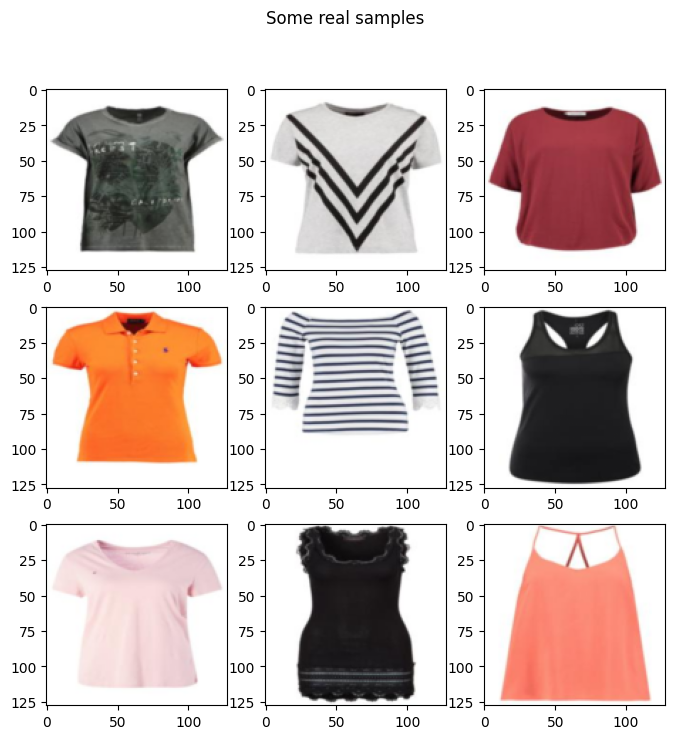

In [4]:
def check_loader():
    loader,_ = get_loader(128)
    cloth,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1

check_loader()

In [5]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [6]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale = (2/in_features) ** 0.5
        self.bias = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

In [7]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [8]:
class PixelNorm(nn.Module):

    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [9]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixelNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [10]:
class AdaIN(nn.Module):

    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale = WSLinear(w_dim, channels)
        self.style_bias = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [11]:
class InjectNoise(nn.Module):

    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
        return x + self.weight * noise

In [12]:
class GenBlock(nn.Module):

    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = InjectNoise(out_channel)
        self.inject_noise2 = InjectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
        
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [13]:
class Generator(nn.Module):

    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = InjectNoise(in_channels)
        self.initial_noise2 = InjectNoise(in_channels)
        self.initial_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )

        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)


    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode='bilinear')
            out = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [16]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [17]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [18]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [19]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1

Curent image size: 4
Epoch [1/ 30


100%|██████████| 64/64 [00:07<00:00,  8.22it/s, gp=3.21, loss_critic=-35.7]  


Epoch [2/ 30


100%|██████████| 64/64 [00:07<00:00,  9.11it/s, gp=0.924, loss_critic=-10.6]


Epoch [3/ 30


100%|██████████| 64/64 [00:07<00:00,  9.08it/s, gp=0.606, loss_critic=-14.4]


Epoch [4/ 30


100%|██████████| 64/64 [00:07<00:00,  9.11it/s, gp=0.601, loss_critic=-16.8]


Epoch [5/ 30


100%|██████████| 64/64 [00:07<00:00,  9.08it/s, gp=0.571, loss_critic=-15.8]


Epoch [6/ 30


100%|██████████| 64/64 [00:06<00:00,  9.18it/s, gp=0.451, loss_critic=-16]  


Epoch [7/ 30


100%|██████████| 64/64 [00:07<00:00,  9.13it/s, gp=0.366, loss_critic=-11.6]


Epoch [8/ 30


100%|██████████| 64/64 [00:06<00:00,  9.16it/s, gp=0.296, loss_critic=-10.8]


Epoch [9/ 30


100%|██████████| 64/64 [00:06<00:00,  9.19it/s, gp=0.301, loss_critic=-10]  


Epoch [10/ 30


100%|██████████| 64/64 [00:06<00:00,  9.16it/s, gp=0.301, loss_critic=-3.14]  


Epoch [11/ 30


100%|██████████| 64/64 [00:07<00:00,  9.13it/s, gp=0.167, loss_critic=-7.69] 


Epoch [12/ 30


100%|██████████| 64/64 [00:06<00:00,  9.17it/s, gp=0.167, loss_critic=-8.85]


Epoch [13/ 30


100%|██████████| 64/64 [00:06<00:00,  9.17it/s, gp=0.185, loss_critic=-7.81]


Epoch [14/ 30


100%|██████████| 64/64 [00:06<00:00,  9.18it/s, gp=0.548, loss_critic=-16.3]


Epoch [15/ 30


100%|██████████| 64/64 [00:07<00:00,  9.14it/s, gp=0.234, loss_critic=-11.4]


Epoch [16/ 30


100%|██████████| 64/64 [00:06<00:00,  9.15it/s, gp=0.28, loss_critic=-10.5] 


Epoch [17/ 30


100%|██████████| 64/64 [00:06<00:00,  9.17it/s, gp=0.637, loss_critic=-22.2]


Epoch [18/ 30


100%|██████████| 64/64 [00:06<00:00,  9.16it/s, gp=0.0786, loss_critic=-3.79] 


Epoch [19/ 30


100%|██████████| 64/64 [00:07<00:00,  9.12it/s, gp=0.102, loss_critic=-4.25] 


Epoch [20/ 30


100%|██████████| 64/64 [00:07<00:00,  9.12it/s, gp=0.0957, loss_critic=-4.32]


Epoch [21/ 30


100%|██████████| 64/64 [00:06<00:00,  9.18it/s, gp=0.185, loss_critic=-8.45]


Epoch [22/ 30


100%|██████████| 64/64 [00:07<00:00,  9.12it/s, gp=0.185, loss_critic=-9.13]


Epoch [23/ 30


100%|██████████| 64/64 [00:06<00:00,  9.17it/s, gp=0.139, loss_critic=-8.94]


Epoch [24/ 30


100%|██████████| 64/64 [00:07<00:00,  9.12it/s, gp=0.123, loss_critic=-6.98]


Epoch [25/ 30


100%|██████████| 64/64 [00:06<00:00,  9.15it/s, gp=0.125, loss_critic=-.927]


Epoch [26/ 30


100%|██████████| 64/64 [00:06<00:00,  9.15it/s, gp=0.0604, loss_critic=-3.58]


Epoch [27/ 30


100%|██████████| 64/64 [00:06<00:00,  9.15it/s, gp=0.0786, loss_critic=-5.14]


Epoch [28/ 30


100%|██████████| 64/64 [00:06<00:00,  9.16it/s, gp=0.0943, loss_critic=-4.7] 


Epoch [29/ 30


100%|██████████| 64/64 [00:06<00:00,  9.15it/s, gp=0.129, loss_critic=-6.48] 


Epoch [30/ 30


100%|██████████| 64/64 [00:06<00:00,  9.17it/s, gp=0.0975, loss_critic=-5.6] 


Curent image size: 8
Epoch [1/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0113, loss_critic=-1.28] 


Epoch [2/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0253, loss_critic=-2.71]


Epoch [3/ 30


100%|██████████| 64/64 [00:15<00:00,  4.00it/s, gp=0.0373, loss_critic=-3.41]


Epoch [4/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0313, loss_critic=-2.78]


Epoch [5/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0703, loss_critic=-2.65]


Epoch [6/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0408, loss_critic=-2.9] 


Epoch [7/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0593, loss_critic=-2.93]


Epoch [8/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0521, loss_critic=-3.12]


Epoch [9/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0364, loss_critic=-2.85]


Epoch [10/ 30


100%|██████████| 64/64 [00:15<00:00,  4.00it/s, gp=0.0602, loss_critic=-2.41]


Epoch [11/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0607, loss_critic=-2.26]


Epoch [12/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0536, loss_critic=-3.36]


Epoch [13/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0332, loss_critic=-3.1] 


Epoch [14/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0641, loss_critic=-3.6] 


Epoch [15/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0364, loss_critic=-2.88]


Epoch [16/ 30


100%|██████████| 64/64 [00:15<00:00,  4.00it/s, gp=0.0574, loss_critic=-3.62]


Epoch [17/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0191, loss_critic=-3.1] 


Epoch [18/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0188, loss_critic=-2.58]


Epoch [19/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0163, loss_critic=-2.98]


Epoch [20/ 30


100%|██████████| 64/64 [00:15<00:00,  4.03it/s, gp=0.0268, loss_critic=-2.75]


Epoch [21/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0354, loss_critic=-2.61]


Epoch [22/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0304, loss_critic=-2.98]


Epoch [23/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0249, loss_critic=-2.81]


Epoch [24/ 30


100%|██████████| 64/64 [00:15<00:00,  4.00it/s, gp=0.0205, loss_critic=-2.81]


Epoch [25/ 30


100%|██████████| 64/64 [00:16<00:00,  4.00it/s, gp=0.0142, loss_critic=-2.42]


Epoch [26/ 30


100%|██████████| 64/64 [00:16<00:00,  4.00it/s, gp=0.053, loss_critic=-2.74] 


Epoch [27/ 30


100%|██████████| 64/64 [00:15<00:00,  4.02it/s, gp=0.0367, loss_critic=-3.1] 


Epoch [28/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0228, loss_critic=-3.15]


Epoch [29/ 30


100%|██████████| 64/64 [00:15<00:00,  4.01it/s, gp=0.0141, loss_critic=-2.53]


Epoch [30/ 30


100%|██████████| 64/64 [00:16<00:00,  4.00it/s, gp=0.0278, loss_critic=-3.35]


Curent image size: 16
Epoch [1/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0401, loss_critic=-2.77]


Epoch [2/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0214, loss_critic=-2.22]


Epoch [3/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0399, loss_critic=-1.05]


Epoch [4/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0168, loss_critic=-1.63]


Epoch [5/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0764, loss_critic=-2.2] 


Epoch [6/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0352, loss_critic=-2.31]


Epoch [7/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0262, loss_critic=-1.73]


Epoch [8/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0165, loss_critic=-1.51]


Epoch [9/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0176, loss_critic=-1.11]


Epoch [10/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0268, loss_critic=-1.47]


Epoch [11/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0205, loss_critic=-1.45]


Epoch [12/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0355, loss_critic=-1.77]


Epoch [13/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0173, loss_critic=-1.63]


Epoch [14/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0245, loss_critic=-1.13]


Epoch [15/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0283, loss_critic=-1.83]


Epoch [16/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0364, loss_critic=-1.68]


Epoch [17/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0208, loss_critic=-1.28]


Epoch [18/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0377, loss_critic=-1.61]


Epoch [19/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0155, loss_critic=-1.1] 


Epoch [20/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0228, loss_critic=-1.31]


Epoch [21/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0433, loss_critic=-1.25]


Epoch [22/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0198, loss_critic=-.965]


Epoch [23/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.032, loss_critic=-.97]  


Epoch [24/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0231, loss_critic=-1.08]


Epoch [25/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0178, loss_critic=-.765] 


Epoch [26/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0354, loss_critic=-.763]


Epoch [27/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0135, loss_critic=-.966]


Epoch [28/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0138, loss_critic=-.832]


Epoch [29/ 30


100%|██████████| 127/127 [00:44<00:00,  2.86it/s, gp=0.0397, loss_critic=-.789] 


Epoch [30/ 30


100%|██████████| 127/127 [00:44<00:00,  2.85it/s, gp=0.0204, loss_critic=-1.53]


Curent image size: 32
Epoch [1/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0513, loss_critic=-1.47] 


Epoch [2/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0155, loss_critic=-.45] 


Epoch [3/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.0173, loss_critic=-1.4]   


Epoch [4/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.0202, loss_critic=-1.12] 


Epoch [5/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.0213, loss_critic=-.874]


Epoch [6/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0172, loss_critic=-.239] 


Epoch [7/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0187, loss_critic=-.939] 


Epoch [8/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0442, loss_critic=-.823] 


Epoch [9/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0383, loss_critic=-.538] 


Epoch [10/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0181, loss_critic=-1.11] 


Epoch [11/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0362, loss_critic=-.37]  


Epoch [12/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0124, loss_critic=-1.61] 


Epoch [13/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.016, loss_critic=-1.2]   


Epoch [14/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.00795, loss_critic=-.514]


Epoch [15/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.0196, loss_critic=-.865] 


Epoch [16/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0126, loss_critic=-1.53] 


Epoch [17/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.0163, loss_critic=-1.36] 


Epoch [18/ 30


100%|██████████| 254/254 [01:55<00:00,  2.20it/s, gp=0.0259, loss_critic=-.69]  


Epoch [19/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.00858, loss_critic=-1.56]


Epoch [20/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.01, loss_critic=-.499]   


Epoch [21/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0189, loss_critic=-.4]     


Epoch [22/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0126, loss_critic=-1.03] 


Epoch [23/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0133, loss_critic=-.0965] 


Epoch [24/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0138, loss_critic=-.818] 


Epoch [25/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0227, loss_critic=0.124]  


Epoch [26/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.00961, loss_critic=-.434] 


Epoch [27/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.00835, loss_critic=-.563]


Epoch [28/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0156, loss_critic=-.202]  


Epoch [29/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.0126, loss_critic=-.386]  


Epoch [30/ 30


100%|██████████| 254/254 [01:55<00:00,  2.21it/s, gp=0.00958, loss_critic=-.548] 


Curent image size: 64
Epoch [1/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0152, loss_critic=-2.1]  


Epoch [2/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0109, loss_critic=-.557]  


Epoch [3/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0145, loss_critic=-2.33]  


Epoch [4/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0166, loss_critic=-3.07]  


Epoch [5/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0108, loss_critic=0.00992]


Epoch [6/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0137, loss_critic=-.947] 


Epoch [7/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0635, loss_critic=-2.35]  


Epoch [8/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0285, loss_critic=-1.65]  


Epoch [9/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0112, loss_critic=-1.83]  


Epoch [10/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.016, loss_critic=-.223]    


Epoch [11/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0291, loss_critic=-1.35]  


Epoch [12/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0123, loss_critic=-1.73]  


Epoch [13/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.024, loss_critic=-1.72]   


Epoch [14/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0096, loss_critic=-2.87]  


Epoch [15/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0181, loss_critic=-4.45]   


Epoch [16/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0284, loss_critic=-.462]   


Epoch [17/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0215, loss_critic=-1.34]   


Epoch [18/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0228, loss_critic=1.41]   


Epoch [19/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.011, loss_critic=-2.71]     


Epoch [20/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0302, loss_critic=0.981]   


Epoch [21/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0256, loss_critic=0.313]   


Epoch [22/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0166, loss_critic=-.312]  


Epoch [23/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.00733, loss_critic=-2.04]  


Epoch [24/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0096, loss_critic=-4.5]    


Epoch [25/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0104, loss_critic=-1.41]  


Epoch [26/ 30


100%|██████████| 508/508 [03:20<00:00,  2.53it/s, gp=0.0262, loss_critic=-1.5]   


Epoch [27/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.00491, loss_critic=-1.28] 


Epoch [28/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0338, loss_critic=-1.4]   


Epoch [29/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0143, loss_critic=-1.43]  


Epoch [30/ 30


100%|██████████| 508/508 [03:21<00:00,  2.53it/s, gp=0.0108, loss_critic=-.00365] 


Curent image size: 128
Epoch [1/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0473, loss_critic=2.76]  


Epoch [2/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.62it/s, gp=0.0456, loss_critic=-3.59]


Epoch [3/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0856, loss_critic=-5.52] 


Epoch [4/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.843, loss_critic=-11.6]  


Epoch [5/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0308, loss_critic=-17.2] 


Epoch [6/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.62it/s, gp=0.0511, loss_critic=1.12]  


Epoch [7/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0279, loss_critic=2.87]  


Epoch [8/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0609, loss_critic=-6.26] 


Epoch [9/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0159, loss_critic=-5.72]


Epoch [10/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.187, loss_critic=-8.72]  


Epoch [11/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0787, loss_critic=-1.3] 


Epoch [12/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0226, loss_critic=-5.73] 


Epoch [13/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0726, loss_critic=0.691]


Epoch [14/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.124, loss_critic=-1.94]  


Epoch [15/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.0275, loss_critic=-20.2] 


Epoch [16/ 30


100%|██████████| 1015/1015 [06:28<00:00,  2.61it/s, gp=0.128, loss_critic=-.694]  


Epoch [17/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0143, loss_critic=-2.78]


Epoch [18/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.159, loss_critic=-4.48]  


Epoch [19/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.0709, loss_critic=-19.6] 


Epoch [20/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.105, loss_critic=-3.46]  


Epoch [21/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0508, loss_critic=-.219]


Epoch [22/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.046, loss_critic=1.29]    


Epoch [23/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0686, loss_critic=-2.98] 


Epoch [24/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.0267, loss_critic=-3]    


Epoch [25/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.045, loss_critic=-3.12]  


Epoch [26/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.483, loss_critic=-7.49]  


Epoch [27/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.63it/s, gp=0.0213, loss_critic=9.56]  


Epoch [28/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.465, loss_critic=-7.23]  


Epoch [29/ 30


100%|██████████| 1015/1015 [06:26<00:00,  2.62it/s, gp=0.161, loss_critic=8.38]   


Epoch [30/ 30


100%|██████████| 1015/1015 [06:27<00:00,  2.62it/s, gp=0.0601, loss_critic=-5.78] 
